In [1]:
using Revise

using Ramnet
using Ramnet.Encoders

using StatsBase: msd, rmsd

using Random
using StatsPlots
using Distributions

using Printf

gr()

Plots.GRBackend()

# Regression with Weightless Neural Networks

## Linear data

In [2]:
function line(;seed=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed) 
    intercepts = rand(rng, Uniform(-1, 1), 2)
    a, b = -intercepts[2]/intercepts[1], intercepts[2]
    
    (x) -> a*x + b
end

function target_regression(target;samples=30, res=80, n=10, seed=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)
    t = target(;seed)
    
    X = rand(rng, samples)
    y = t.(X)
    
    thermo = Thermometer(0.0, 1.0, res)
    X_encoded = permutedims(encode(thermo, X; flat=false))
    
    model = RegressionDiscriminator(res, n; seed, γ=1.0)
    
    train!(model, X_encoded, y)

    # Testing
    X_test = 0:0.001:1
    X_test_encoded = permutedims(encode(thermo, X_test; flat=false))
    y_test = t.(X_test)
    y_pred = predict(model, X_test_encoded)
    println("Mean squared deviation: $(msd(y_pred, y_test))")

    plot((x) -> predict(model, encode(thermo, x)), 0:0.001:1, label="Regression curve")
    scatter!(X, y, label="Samples")
end

linear_regression(;kargs...) = target_regression(line; kargs...)

linear_regression (generic function with 1 method)

Mean squared deviation: 0.00042565084137415613


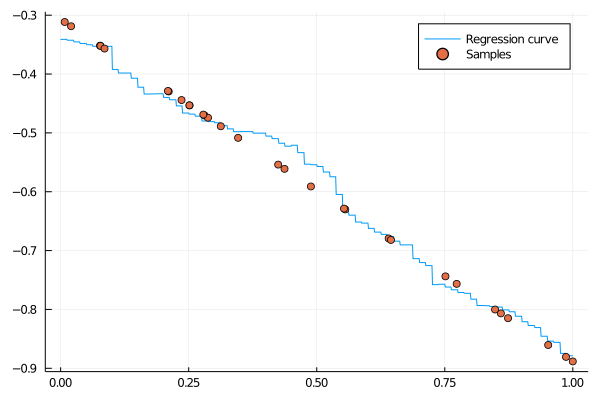

In [3]:
linear_regression(;seed=1)

## Non-linear data

In [4]:
function wiggly(;seed=nothing)
    (x) -> sin(10*π*(x + 1)^(-3)) 
end

wiggly_regression(;kargs...) = target_regression(wiggly; kargs...)

wiggly_regression (generic function with 1 method)

Mean squared deviation: 0.02287930017572298


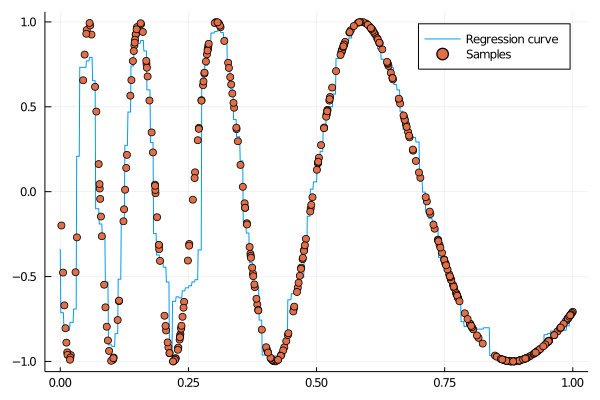

In [5]:
wiggly_regression(;samples=400, res=160, n=80, seed=1)

## Non-stationarity

In the previous examples, we could see that the model is able to adequately approximate both linear and nonlinear functions, but these shared one characteristic: they represented stationary tasks. All samples were drawn uniformly from their respective underlying and unchanging processes. However, not all tasks that are of interest to us share in these conditions. In a reinforcement learning setting, for example, we are usually interested in finding high-valued polices. One possible way of finding such policies is to start with a arbitrary one and iteratively improve it by interating with the environment, collecting data, using it to model the policy's value and conceiving a new, hopefully improved policy acording to the approximate value function. One difficulty presented by this approach is that the value function we strive to approximate is a constantly moving target. That is: it is nonstationary. How does the n-tuple regression network fare under a nonstationary setting such as this one?

In [6]:
function polynomial(c_5, c_4, c_3, c_2, c_1, c_0)
    x -> c_5*x^5 + c_4*x^4 + c_3*x^3 + c_2*x^2 + c_1*x + c_0
end

function nonstationary(seed=nothing; γ=1.0, snapshots=nothing, error_curve=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)
    
    coefs = [
        ( 0.0,  0.0,  0.0, 0.0, 1.0, 0.0),
        ( 0.0,  0.0,  0.0, 0.3, 1.0, 0.0),
        ( 0.0,  0.0, -0.3, 0.3, 1.0, 0.0),
        ( 0.0, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.3, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.4, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0)
    ]
    
    plots = Vector{Plots.Plot}(undef, 9)
    MSEs = Vector{Float64}(undef, 900)
    
    thermo = Thermometer(-1.0, 1.0, 160)
    regressor = RegressionDiscriminator(160, 20; seed, γ)
    
    for (i, coef) in Iterators.enumerate(coefs)
        poly = polynomial(coef...)
        
        # Plot target function
        X_poly = -1:0.001:1
        y_poly = poly.(X_poly)
        
        plots[i] = plot(X_poly, y_poly)
        
        # Sample points from target function to train model and assess quality
        X_train = rand(Uniform(-1, 1), 100)
        y_train = poly.(X_train)
        
        X_test = rand(Uniform(-1, 1), 1000)
        y_test = poly.(X_test)
        
        # Train regression model
        for (j, x, target) in Iterators.zip(
                1:length(X_train),
                eachrow(permutedims(encode(thermo, X_train; flat=false))),
                y_train)
            train!(regressor, x, target)

            MSEs[(i-1)*length(X_train) + j] = msd(
                predict(regressor, permutedims(encode(thermo, X_poly; flat=false))),
                y_poly
            )
        end
        
        # Plot regression curve
        plot!(
            plots[i],
            (x) -> predict(regressor, encode(thermo, x)),
            -1:0.005:1,
            title=@sprintf("MSE: %.2e", MSEs[i * length(X_train)]),
            titlefont=font(9)
        )
    end
    
    # Save the snapshots figure and the error curve figure
    if !isnothing(snapshots)
        snap = plot(
            plots...,
            layout=grid(3,3),
            size=(1000, 1000),
            legend=false,
            dpi=300,
            show=false
        );
        png(
            snap,
            snapshots
        );
    end
    
    if !isnothing(error_curve)
        png(
            plot(
                50:(length(MSEs)),
                MSEs[50:end],
                xlabel="Samples",
                ylabel="MSE",
                size=(800, 400),
                dpi=300,
                legend=false
            ),
            error_curve
        )
    end
    
    # Display snapshots and error curve
    l = @layout [grid(3,3); a{0.3h}]
    
    plot(
        plots...,
        plot(50:(length(MSEs)), MSEs[50:end], xlabel="Samples", ylabel="MSE"),
        layout=l,
        size=(950, 1358),
        legend=false,
        dpi=100
    )
end

nonstationary (generic function with 2 methods)

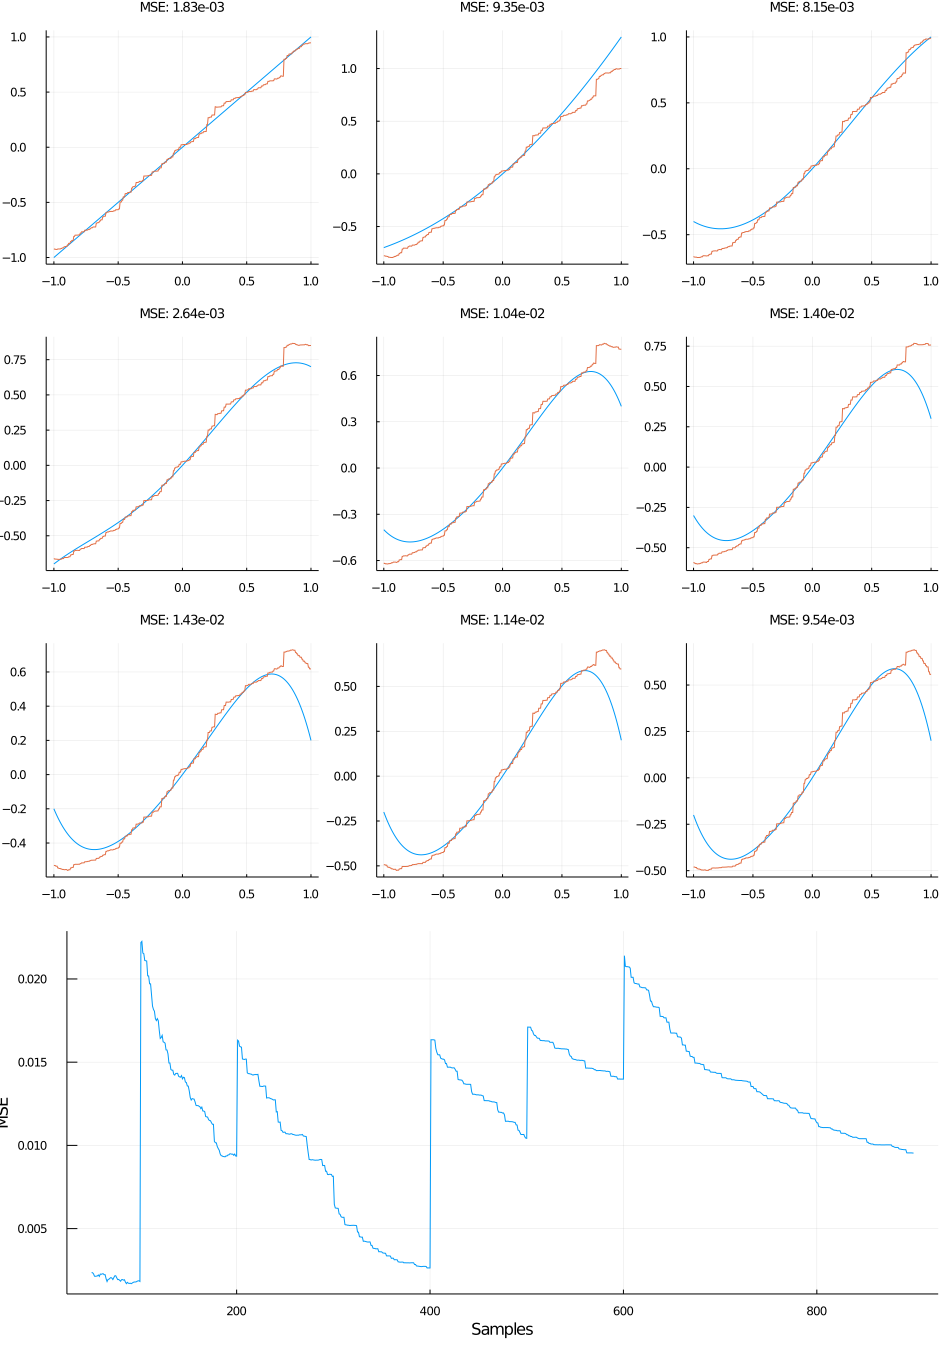

In [7]:
nonstationary(
    4;
    γ = 1.0,
    snapshots="snapshots_simple_averaging",
    error_curve="error_curve_simple_averaging"
)

## What if we penalize older samples?

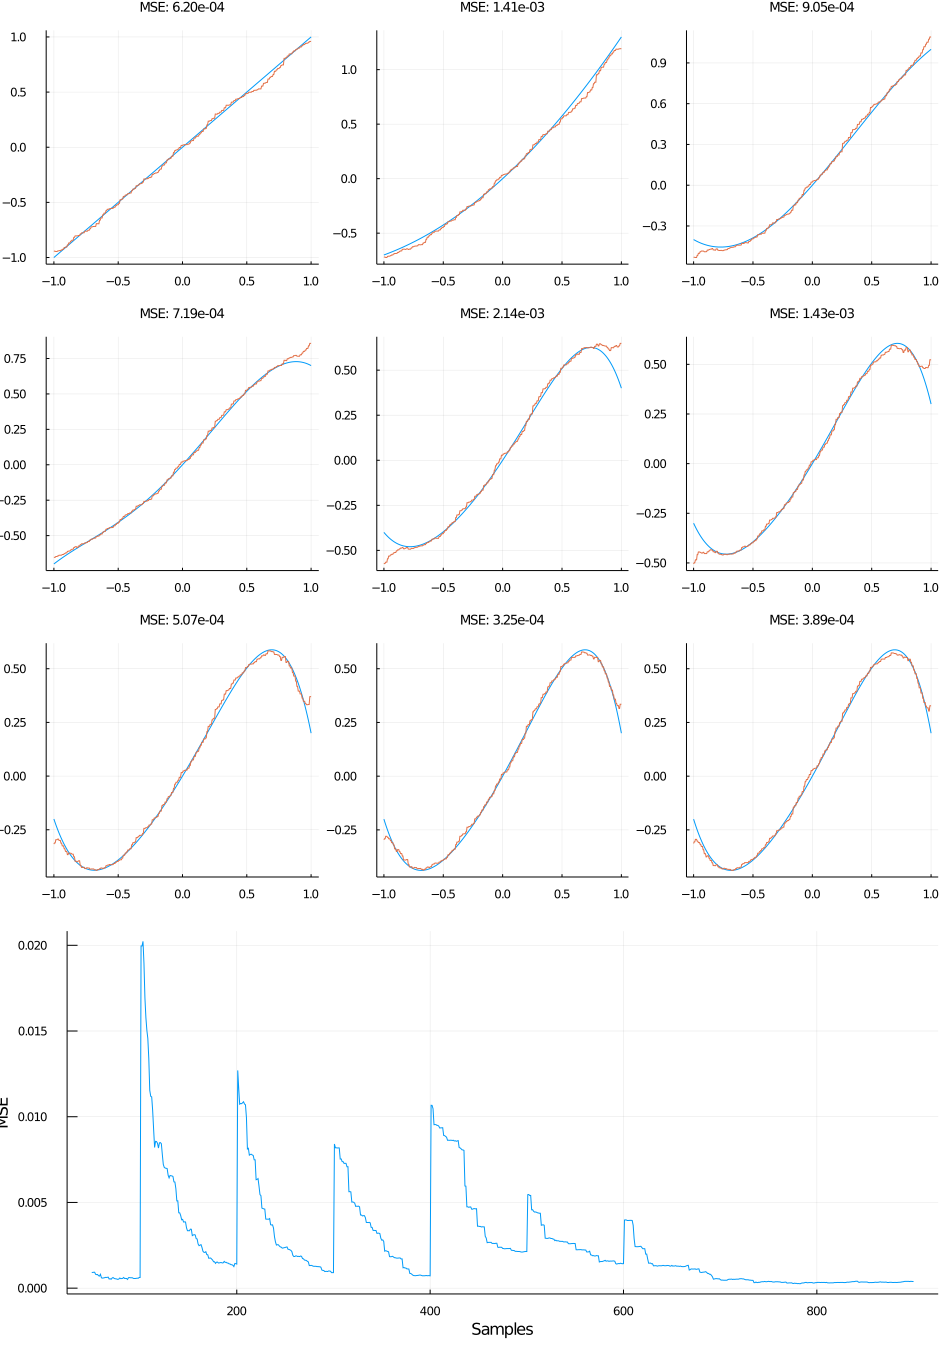

In [8]:
nonstationary(
    4;
    γ = 0.75,
    snapshots="snapshots_gemetric_decay_averaging",
    error_curve="error_curve_geometric_decay_averaging"
)

## The original and discounted regression discriminators are special cases of the generalized regression discriminator

Comparing the step size for the original and discounted regressors:

In [9]:
original_α() = (x) -> 1/x
discounted_α(γ) = (x) -> (1 - γ)/(1 - γ^x)

discounted_α (generic function with 1 method)

In [10]:
png(
    plot(
        [original_α(), discounted_α(0.9), discounted_α(0.7), discounted_α(0.5)],
        0:1:50,
        label=["Original" "γ = 0.9" "γ = 0.7" "γ = 0.5"],
        xlabel="Samples",
        ylabel="α",
        lw=2.3,
        dpi=300
    ),
    "step_sizes"
)

# Testing the generalized Discriminator

In [11]:
function generalized_nonstationary(seed=nothing; α=0.5, snapshots=nothing, error_curve=nothing)
    rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)
    
    coefs = [
        ( 0.0,  0.0,  0.0, 0.0, 1.0, 0.0),
        ( 0.0,  0.0,  0.0, 0.3, 1.0, 0.0),
        ( 0.0,  0.0, -0.3, 0.3, 1.0, 0.0),
        ( 0.0, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.3, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.4, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0),
        (-0.5, -0.3, -0.3, 0.3, 1.0, 0.0)
    ]
    
    plots = Vector{Plots.Plot}(undef, 9)
    MSEs = Vector{Float64}(undef, 900)
    
    thermo = Thermometer(-1.0, 1.0, 160)
    regressor = GeneralizedRegressionDiscriminator(160, 20; seed, α)
    
    for (i, coef) in Iterators.enumerate(coefs)
        poly = polynomial(coef...)
        
        # Plot target function
        X_poly = -1:0.001:1
        y_poly = poly.(X_poly)
        
        plots[i] = plot(X_poly, y_poly)
        
        # Sample points from target function to train model and assess quality
        X_train = rand(Uniform(-1, 1), 100)
        y_train = poly.(X_train)
        
        X_test = rand(Uniform(-1, 1), 1000)
        y_test = poly.(X_test)
        
        # Train regression model
        for (j, x, target) in Iterators.zip(
                1:length(X_train),
                eachrow(permutedims(encode(thermo, X_train; flat=false))),
                y_train)
            train!(regressor, x, target)

            # @show predict(regressor, permutedims(encode(thermo, X_poly; flat=false)))
            # return
            MSEs[(i-1)*length(X_train) + j] = msd(
                predict(regressor, permutedims(encode(thermo, X_poly; flat=false))),
                y_poly
            )
        end
        
        # Plot regression curve
        plot!(
            plots[i],
            (x) -> predict(regressor, encode(thermo, x)),
            -1:0.005:1,
            title=@sprintf("MSE: %.2e", MSEs[i * length(X_train)]),
            titlefont=font(9)
        )
    end
    
    # Save the snapshots figure and the error curve figure
    if !isnothing(snapshots)
        snap = plot(
            plots...,
            layout=grid(3,3),
            size=(1000, 1000),
            legend=false,
            dpi=300,
            show=false
        );
        png(
            snap,
            snapshots
        );
    end
    
    if !isnothing(error_curve)
        png(
            plot(
                50:(length(MSEs)),
                MSEs[50:end],
                xlabel="Samples",
                ylabel="MSE",
                size=(800, 400),
                dpi=300,
                legend=false
            ),
            error_curve
        )
    end
    
    # Display snapshots and error curve
    l = @layout [grid(3,3); a{0.3h}]
    
    plot(
        plots...,
        plot(50:(length(MSEs)), MSEs[50:end], xlabel="Samples", ylabel="MSE"),
        layout=l,
        size=(950, 1358),
        legend=false,
        dpi=100
    )
end

generalized_nonstationary (generic function with 2 methods)

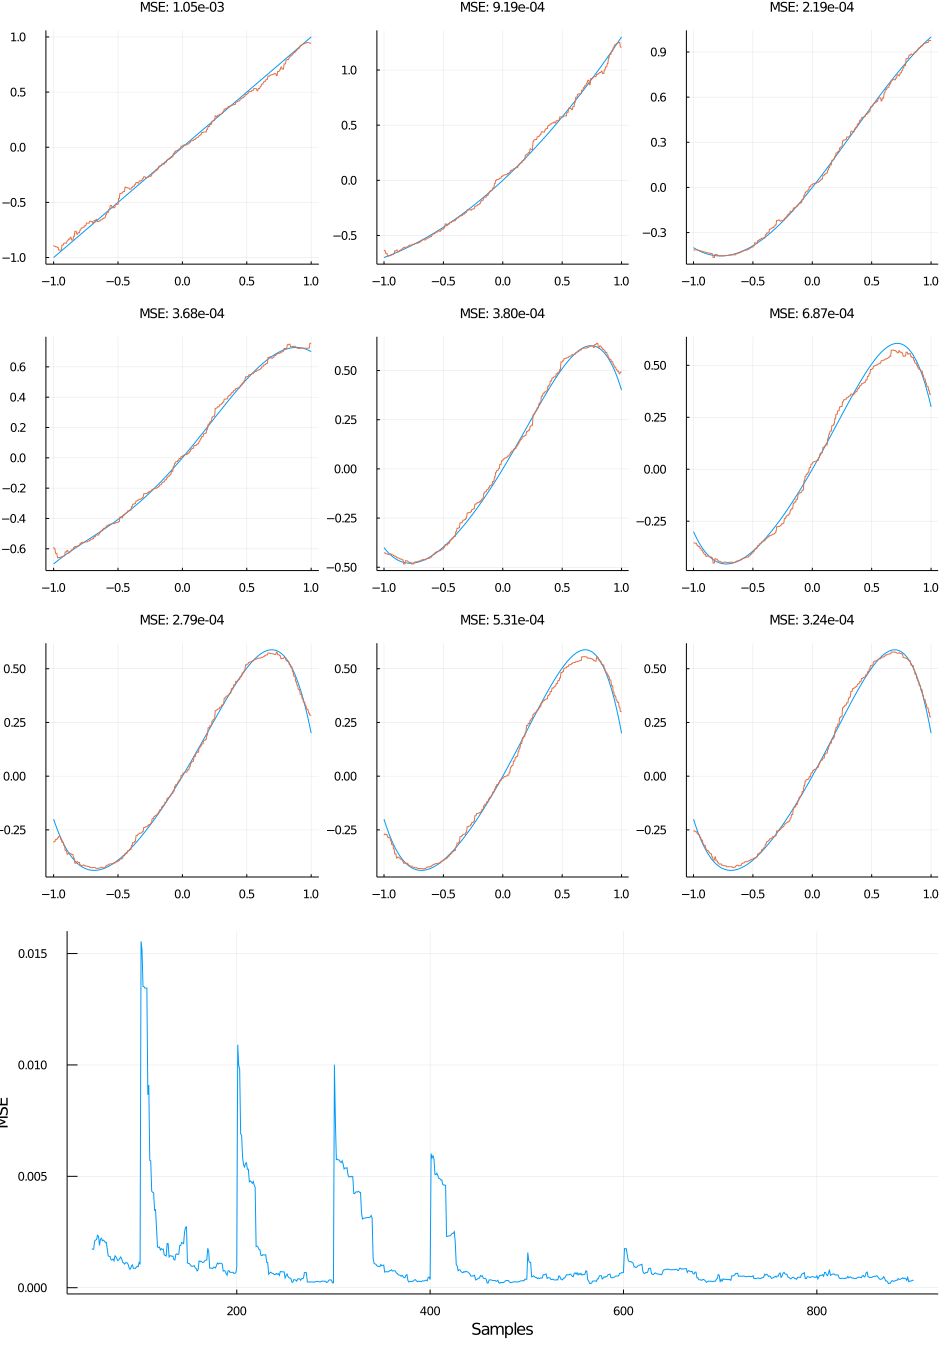

In [12]:
generalized_nonstationary(4; α=0.7)

Mean squared deviation: 0.00024265368363463727


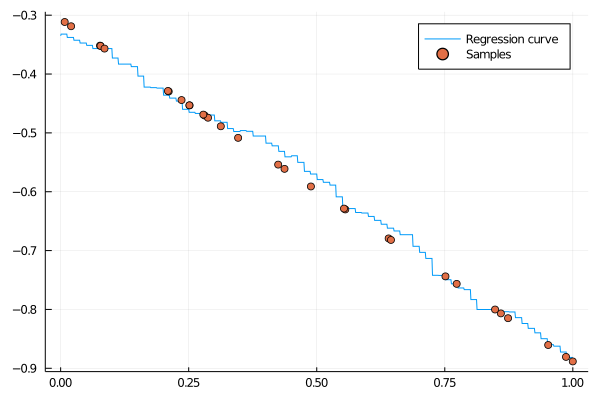

In [13]:
seed = 1
rng = isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)

thermo = Thermometer(0.0, 1.0, 80)
regressor = GeneralizedRegressionDiscriminator(80, 10;seed, α=1.0)

t = line(;seed)
    
X = rand(rng, 30)
y = t.(X)

X_encoded = permutedims(encode(thermo, X; flat=false))

train!(regressor, X_encoded, y)

# Testing
X_test = 0:0.001:1
X_test_encoded = permutedims(encode(thermo, X_test; flat=false))
y_test = t.(X_test)
y_pred = predict(regressor, X_test_encoded)

println("Mean squared deviation: $(msd(y_pred, y_test))")

plot((x) -> predict(regressor, encode(thermo, x)), 0:0.001:1, label="Regression curve")
scatter!(X, y, label="Samples")